# Single Source Shortest Path


Below is an implementation of a Wavefront algorithm using spiking neurons. \
An in depth description of such an algorithm can be viewed in [0].\
The algorithm is implemented using the [Loihi emulator](https://github.com/sagacitysite/brian2_loihi) described in [1].\
Concrete values and the learning rule are taken from the PathPlanning library provided by Intel via their NxSDK Apps package (you have to be INRC member to get the package).

In summary the idea is that a wave of neuron spikes is running trough a lattice graph - a lattice graph is a rectangle of nodes where every node is, if possible, connected to their four surounding neigbours - until the spike front hits the target node / neuron. \
Path backtracing is done via the synaptic weights, which are altered by an anti hebbian leraning rule to enable a change in the weight that can be backtraced to reconstruct the shortest path.

[0] Ponulak F, Hopfield JJ. Rapid, parallel path planning by propagating wavefronts of spiking neural activity. Front Comput Neurosci. 2013 Jul 18;7:98. doi: 10.3389/fncom.2013.00098. PMID: 23882213; PMCID: PMC3714542.

[1] Brian2Loihi: An emulator for the neuromorphic chip Loihi using the spiking neural network simulator Brian
Carlo Michaelis, Andrew B. Lehr, Winfried Oed, Christian Tetzlaff


In [1]:
# ------------------------------
#       import libs
# ------------------------------
from brian2_loihi import *
# change to numpy to skip compilation time
from brian2 import *
prefs.codegen.target = 'numpy'
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import time as time


# ------------------------------
#       variables
# ------------------------------
# Graph size
N = 7
sim_steps = N*2 # in a lattice graph this is the maximal path length

# the maximal length for a path in a lattice graph is N*2,
# which would be a path going from one corner to the one in front of.
# Therefore the simulation needs to be a max as long as N*2 steps
# since then the spikefront would have hit the target definitely.
net_runtime = N*2 

# target and source neuron
# it is the number of the neuron inside the graph (counting starts at zero!).
# To generate one of the longest possible paths do:
source_neuron = N*N-1
target_neuron = 0

In [2]:
# This fully connected function takes useless amounts of memorys as
# it is better to represetn hte connections via indices and target lists.
def fully_connected_nxn_graph(N):
    """
    Creates a fully connected N x N Graph connection matrix that uses
    an insane amount of memory !
    """
    # make empty matrix
    A = np.zeros((N*N,N*N), dtype=int)
    
    # make connections
    for n in range(N*N):
        # left neigbour
        if n%N > 0:
            A[n][n-1] = 1
        
        # right neigbour
        if ((n+1)/N) - int((n+1)/N) > 0:
            A[n][n+1] = 1
        
        # upper neigbour
        if n >= N:
            A[n][n-N] = 1
        
        # lower neigbour
        if n < N*N - N:
            A[n][n+N] = 1
        
    return A


def fully_connected_nxn_graph_it(N):
    """
    Creates a fully connected N x N Graph represented as indices and targets
    """
    # make lists
    indices = []
    targets = []
    
    # make connections
    for n in range(N*N):
        # left neigbour
        if n%N > 0:
            #A[n][n-1] = 1
            indices.append(n)
            targets.append(n-1)
        
        # right neigbour
        if ((n+1)/N) - int((n+1)/N) > 0:
            #A[n][n+1] = 1
            indices.append(n)
            targets.append(n+1)
        
        # upper neigbour
        if n >= N:
            #A[n][n-N] = 1
            indices.append(n)
            targets.append(n-N)
            
        
        # lower neigbour
        if n < N*N - N:
            #A[n][n+N] = 1
            indices.append(n)
            targets.append(n+N)
        
    return indices, targets

# Define a Graph

In [3]:
# define graphs for drawing the path with the networkx library
C = fully_connected_nxn_graph(N)

size_in_bytes = C.nbytes
size_in_Kbytes = size_in_bytes/1024
size_in_Mbytes = size_in_Kbytes/1024
size_in_Gbytes = size_in_Mbytes/1024

print('Graph memory size')
print('byte: ', size_in_bytes)
print('Kbytes : ', size_in_Kbytes)
print('Mbytes : ', size_in_Mbytes)
print('Gbytes : ', size_in_Gbytes)


# make it for indices targets versi0n for use with brian
indices, targets = fully_connected_nxn_graph_it(N)

size_in_bytes = np.array(indices).nbytes
size_in_Kbytes = size_in_bytes/1024
size_in_Mbytes = size_in_Kbytes/1024
size_in_Gbytes = size_in_Mbytes/1024

print()
print('Graph memory size indices, targets')
print('byte: ', size_in_bytes)
print('Kbytes : ', size_in_Kbytes)
print('Mbytes : ', size_in_Mbytes)
print('Gbytes : ', size_in_Gbytes)

Graph memory size
byte:  19208
Kbytes :  18.7578125
Mbytes :  0.01831817626953125
Gbytes :  1.788884401321411e-05

Graph memory size indices, targets
byte:  1344
Kbytes :  1.3125
Mbytes :  0.00128173828125
Gbytes :  1.2516975402832031e-06


# Make a network that represents the Graph

In [4]:
# ------------------------------
#       Define network 
# ------------------------------
# how many nodes/neurons are present in the lattice Graph?
num_nodes = N*N

# define nodes as neurons
neuron_nodes = LoihiNeuronGroup(
    num_nodes,
    refractory=63,      # set the refractory relatively high to prevent spiking
    threshold_v_mant=1, # 64 = 1*2**6
    decay_v=3000,       # set the voltage decay relatively high to not sum up 2 much
    decay_I=4095        # set the input to zero after every time step
)

# create source and target list from adjacency matrix
sources, targets = fully_connected_nxn_graph_it(N)

# define anti hebbian learning rule
# this will leave a trace from the wavefront algorithm
# inside the connection strength of the synaptic connections.
anti_hebb_learn = 'x0*y1 - y0*x1'

# define synapses with learning rule and proper synaptic traces
syn_connection = LoihiSynapses(source=neuron_nodes,
                               target=neuron_nodes,
                               dw = anti_hebb_learn,
                               w_exp = 0,
                               imp_x1 = 127,
                               tau_x1 = 10,
                               imp_y1 = 127,
                               tau_y1 = 10,
                               sign_mode = synapse_sign_mode.MIXED) # could be also 2 = excitatory
syn_connection.connect(i=sources, j=targets)
syn_connection.w = 2 # which is 128 = 2*2**6


# let the target spike at time step t = 0
# create a spike generator for that
generator_target_init = LoihiSpikeGeneratorGroup(1,
                         indices=[0],
                         times=[0])

# connect this spike generator properly
syn_target_init = LoihiSynapses(generator_target_init,
                                neuron_nodes,
                                sign_mode=synapse_sign_mode.EXCITATORY)
syn_target_init.connect(i=0, j=target_neuron)
syn_target_init.w = 2


# monitor every neuron inside the network with a spike monitor
monitor_all = LoihiSpikeMonitor(neuron_nodes, record=True)

# define a network object and add all previosly defined objects to it
net = LoihiNetwork(neuron_nodes,
                   syn_connection,
                   generator_target_init,
                   syn_target_init,
                   monitor_all)

# Run the network until the wave hits the target

In [5]:
#-------------------------------------------
# Workaround for non N*2 runtime (is super slow!):
#-------------------------------------------
# Since the network has to run until the source spikes it is not trivial how long the simualtion runtim shall be.
# Therefore the net runs for 1 step and then checks if the source spiked or not
# this massively slows down the network simulation speed.
# It is therefore a workaround to run the network one time step,
# then check if the target spiked and if not continue running until the target spiked.


# start path search and measure how many steps the net needs to be runned
#net_runtime = 0
#while source_neuron not in monitor_all.i:
#    net.run(1)
#    net_runtime += 1

# make one final step so that weights are updated
#net.run(1)


print('Running wavefront for ',net_runtime, ' steps')



# -------------------------------------------
#    Letting the net run the full runtime
# -------------------------------------------
# run and measure time
start_time = time.time()
net.run(net_runtime, report='text')
SSSP_brian_network_runtime = time.time() - start_time
print('Net needed ', SSSP_brian_network_runtime, ' seconds to simulate')


# -------------------------------------------
#       trace back the path
# -------------------------------------------
# get path length
path_length = max(monitor_all.t)+1 # counting starts at zero therefore add 1
SSP_path_length_brian = path_length

# array for the path
SSP_path_brian = np.zeros(path_length+1, dtype=int)

# save weights
weights = syn_connection.w_clipped

# starting point
post_neuron = source_neuron

# measure time
start_time = time.time()

# walk the path until destination reached
i = 0
SSP_path_brian[i] = post_neuron
while post_neuron != target_neuron:
    
    # connections for the post_neuron in form of the weight
    connections = weights[np.where(syn_connection.j == post_neuron)[0]]
    
    # find the connections where the wave propagation changed the weight
    wave_walk = np.where(connections < 2)[0]
    
    # we only want to walk one path if two available choose the first one
    wave_walk = wave_walk[0]
    
    # find the presynaptic neuron of that connection
    # get all indexes with that postsyn neuron and choose the index with the right (wave_walk) connection
    conn_index = np.where(syn_connection.j == post_neuron)[0][wave_walk]
    
    # now we know the presyn neuron as it is at the same index in the syn.i array
    pre_neuron = syn_connection.i[conn_index]
    
    # we walked the path, start from the new stand point
    post_neuron = pre_neuron
    
    # update path
    i += 1
    SSP_path_brian[i] = post_neuron

SSSP_brian_pathtracingtime = time.time() - start_time
print('path backtracing took ', SSSP_brian_pathtracingtime, ' seconds')

Running wavefront for  14  steps
Starting simulation at t=0. s for a duration of 14. ms
14. ms (100%) simulated in < 1s
Net needed  0.3698136806488037  seconds to simulate
path backtracing took  0.1148533821105957  seconds


# Path ResultS

Path informations
-------
Shortest path length: 13
Path nodes: [ 0  0  1  2  3  4  5  6 13 20 27 34 41 48]
Numpy backend run time: 0.3698136806488037 s
Path backtrace time: 0.1148533821105957 s


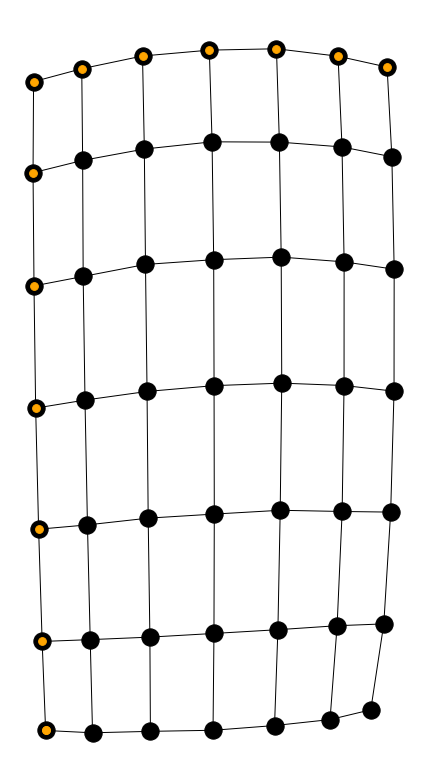

In [11]:
print('Path informations')
print('-------')
print('Shortest path length:', SSP_path_length_brian)
print('Path nodes:', SSP_path_brian[::-1])
print('Numpy backend run time:', SSSP_brian_network_runtime,'s')
print('Path backtrace time:', SSSP_brian_pathtracingtime,'s')

# Draw the Graph and the Paths with networkx library
G = nx.from_numpy_matrix(C)
pos = nx.spring_layout(G)

plt.figure(figsize=(16,14))
subax1 = plt.subplot(121)
nx.draw(G,pos,node_color='#000000')
nx.draw_networkx_nodes(G,pos,nodelist=SSP_path_brian[::-1],node_color='orange', node_size=60)

plt.show()